In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh
%matplotlib inline

# 公式ノートブックの実装を参考

## 計画行列

In [23]:
def gen_desmat_gaussian(X, params):
    '''
    Parameters
    ---------------
    X : 2-D numpy array
    
    params : dictionary
    
    Returns
    ----------
    Phi : 2-D numpy array
    
    '''
    s = params['s']
    mus = params['mus']
    Phi = np.zeros((len(X),len(mus)+1))
    Phi[:,0] = np.ones(len(X)) # the 0-the basis is a constant
    A = ( -2*(X@(mus.T)) + np.reshape(np.sum(X**2, axis=1), (len(X), -1)) ) + np.sum(mus**2, axis=1)
    Phi[:,1:] = np.exp(-A/(2*s*s))
    return Phi

## 線形回帰モデル
PRML  
151P ベイズ線形回帰  
155P 予測分布  
168P エビデンス近似

In [36]:
class BayesianRidgeRegression:
    
    def __init__(self, alpha=1.0, beta=1.0):
        self.alpha = alpha
        self.beta = beta
        self.m = None
        self.S = None
      
    # 事後分布の期待値mと共分散行列の計算
    def calc_posterior_params(self, Phi, t):
        self.S = np.linalg.inv(self.alpha*np.identity(len(Phi[0])) + self.beta*(Phi.T)@Phi)
        self.m = self.beta*(self.S@(Phi.T)@t)
    
    # 予測分布の計算
    def predict(self, Phi, return_std=False):
        pred_mean = Phi@self.m
        if not(return_std):
            return pred_mean
        
        else:
            pred_std = np.sqrt(1.0/self.beta + np.diag(Phi@self.S@(Phi.T)))
            return pred_mean, pred_std
    
    # エビデンスの対数値を計算
    def calc_evidence(self, Phi, t):
        N, M = np.shape(Phi)
        evidence = 0.5*M*np.log(self.alpha) + 0.5*N*np.log(self.beta) \
            -0.5*self.beta*np.linalg.norm(t - Phi@self.m)**2 - 0.5*self.alpha*(self.m@self.m) \
            -0.5*np.log(np.linalg.det(self.alpha*np.identity(M) + self.beta*(Phi.T)@Phi)) \
            -0.5*N*np.log(2*np.pi)
    
        return evidence
    
    def empirical_bayes(self, Phi, t, tol, maxiter, show_message=True):
        
        # 固有値lambdaを求める
        tmp_lambdas = eigh((Phi.T)@Phi)[0]
        cnt = 0
        while cnt < maxiter:
            lambdas = self.beta * tmp_lambdas
            self.calc_posterior_params(Phi, t)
            
            alpha_old = self.alpha
            beta_old = self.beta
            
            gamma = np.sum(lambdas / (self.alpha + lambdas))
            self.alpha = gamma / np.dot(self.m, self.m)
            self.beta = (len(t) - gamma) / (np.linalg.norm(t - Phi@self.m)**2)
            if (abs(self.alpha - alpha_old<tol)) and (abs(self.beta - beta_old) < tol):
                break
            
            cnt += 1
            if show_message:
                if cnt <= maxiter:
                    print(f'Optimization terminated succesfully. The number of iteration : {cnt}')
                else:
                    print("Maximum number of iteration exceeded.")
                    
    def fit(self, Phi, t, tol=1e-4, maxiter=100, show_message=True, optimize_hyperparams=False):
        if optimize_hyperparams:
            self.empirical_bayes(Phi, t, tol, maxiter, show_message)
        self.calc_posterior_params(Phi, t)

## 実際にベイズ線形回帰を行う

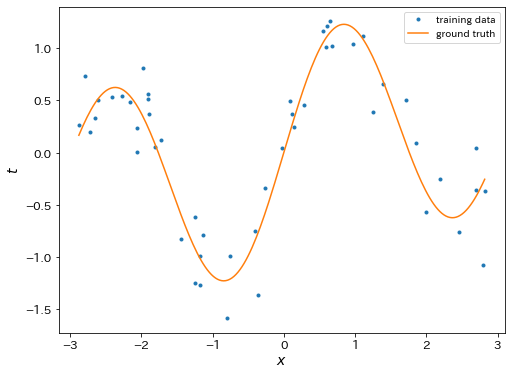

In [24]:
def truef(x):
    return np.sin(2*x)  + 0.2*np.sin(x) + 0.1*x

N = 50
X = np.random.uniform(-3, 3, N)
ep = 0.3*np.random.randn(N)
t = truef(X) + ep

Xcont = np.linspace(np.min(X),np.max(X),200) # for plotting

plt.figure(figsize=(8,6))
plt.plot(X, t,'.', label='training data')
plt.plot(Xcont, truef(Xcont), label='ground truth')
plt.xlabel(r'$x$')
plt.ylabel(r'$t$')
plt.legend()
plt.show()

X = np.reshape(X,(len(X),1))
Xtest = np.reshape(Xcont,(len(Xcont),1))

In [25]:
def plot_result(pred_mean, pred_std):
    plt.figure(figsize=(8,6))
    plt.plot(X, t,'.',label='training data')
    plt.plot(Xcont, pred_mean, label='predictive mean')
    plt.plot(Xcont, truef(Xcont), ':', label='ground truth')
    plt.fill_between(Xcont, pred_mean + pred_std, pred_mean - pred_std, alpha=0.2)
    plt.xlabel(r'$x$')
    plt.ylabel(r'$t$')
    plt.legend()
    plt.show()    

def plot_prediction_fixed_hparams(s, mus, alpha, beta):
    # generating design matrix
    Phi = gen_desmat_gaussian(X,params={'s':s, 'mus':mus})
    Phi_test = gen_desmat_gaussian(Xtest,params={'s':s, 'mus':mus})
    
    est = BayesianRidgeRegression(alpha=alpha, beta=beta)
    est.fit(Phi, t, optimize_hyperparams=False)
    pred_mean, pred_std = est.predict(Phi_test, return_std=True)
    plot_result(pred_mean, pred_std)


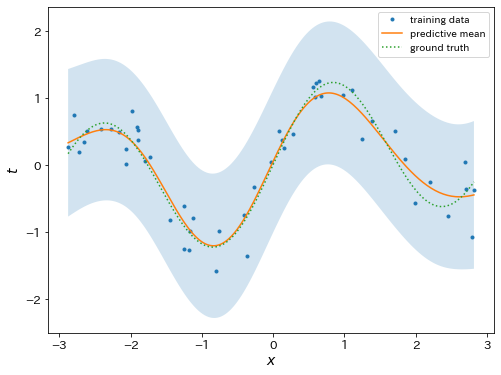

In [30]:
mus = np.reshape(np.linspace(-3,3,16),(16,1))
s = 0.5
plot_prediction_fixed_hparams(s, mus, alpha=1.0, beta=1.0)

ハイパラを変えた場合

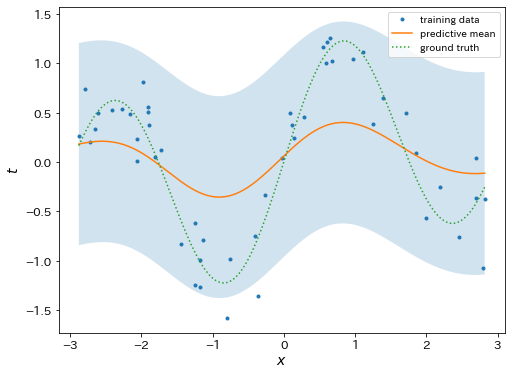

In [31]:
mus = np.reshape(np.linspace(-3,3,16),(16,1))
s = 0.5
plot_prediction_fixed_hparams(s, mus, alpha=30.0, beta=1.0)

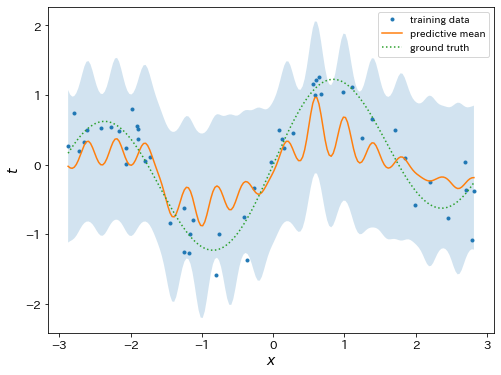

In [32]:
mus = np.reshape(np.linspace(-3,3,16),(16,1))
s = 0.1
plot_prediction_fixed_hparams(s, mus, alpha=1.0, beta=1.0)

##  エビデンス近似によるハイパラ調整

Optimization terminated succesfully. The number of iteration : 1
Optimization terminated succesfully. The number of iteration : 2
Optimization terminated succesfully. The number of iteration : 3
alpha=4.448284052876881 
beta=12.860678264859217


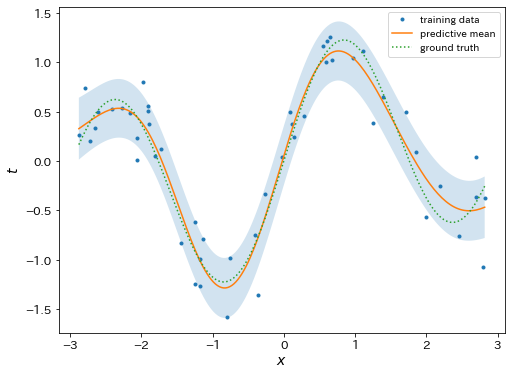

In [37]:
mus = np.reshape(np.linspace(-3,3,16),(16,1))
s = 0.5
params = {'s':s, 'mus':mus}
Phi = gen_desmat_gaussian(X, params = {'s':s, 'mus':mus})
Phi_test = gen_desmat_gaussian(Xtest,params={'s':s, 'mus':mus})

est = BayesianRidgeRegression(alpha = 1.0, beta=1.0)
est.fit(Phi, t, optimize_hyperparams=True)
pred_mean, pred_std = est.predict(Phi_test, return_std=True)

print(f'alpha={est.alpha} \nbeta={est.beta}')
plot_result(pred_mean, pred_std)

## パラメタSの最大化
グリッドサーチによりSの最適化を行う

s=0.60625


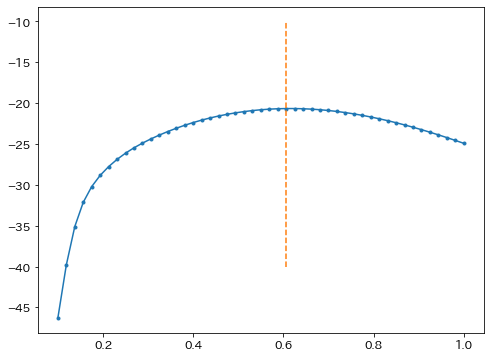

In [39]:
mus = np.reshape(np.linspace(-3, 3, 16), (16, 1))

ss = np.linspace(0.1, 1.0, 49)
arr_evidence = np.zeros(len(ss))

for (cnt, s) in enumerate(ss):
    Phi = gen_desmat_gaussian(X, {'s':s, 'mus':mus})
    est = BayesianRidgeRegression(alpha=1.0, beta=1.0)
    est.fit(Phi, t, tol=1e-4, maxiter=1e3, optimize_hyperparams=True, show_message=False)
    arr_evidence[cnt] = est.calc_evidence(Phi, t)

# 最大となるs
s = ss[np.argmax(arr_evidence)]
print(f's={s}')
plt.figure(figsize=(8,6))
plt.plot(ss, arr_evidence, '.-')
plt.plot([s, s], [-40, -10], '--')
plt.show()

Optimization terminated succesfully. The number of iteration : 1
Optimization terminated succesfully. The number of iteration : 2
Optimization terminated succesfully. The number of iteration : 3
s=0.60625
alpha=3.6348258447529482 
beta=13.024570712161767


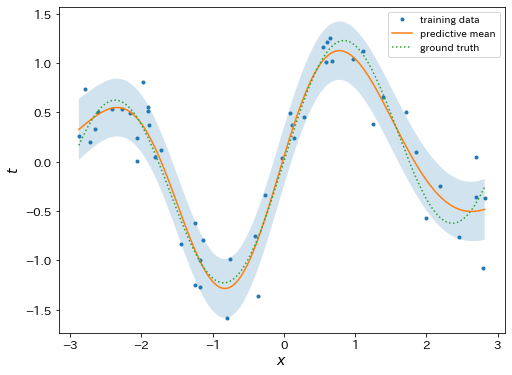

In [41]:
mus = np.reshape(np.linspace(-3,3,16),(16,1))
params = {'s':s, 'mus':mus}
Phi = gen_desmat_gaussian(X, params = {'s':s, 'mus':mus})
Phi_test = gen_desmat_gaussian(Xtest, params = {'s':s, 'mus':mus})

est = BayesianRidgeRegression(alpha=1.0, beta=1.0)
est.fit(Phi, t, optimize_hyperparams=True)
pred_mean, pred_std = est.predict(Phi_test, return_std=True)

print(f"s={s}\nalpha={est.alpha} \nbeta={est.beta}")
plot_result(pred_mean, pred_std)

## scikit-laernによるベイズ線形回帰

s=0.60625
alpha=3.634824660521371 
beta=13.02456247153152


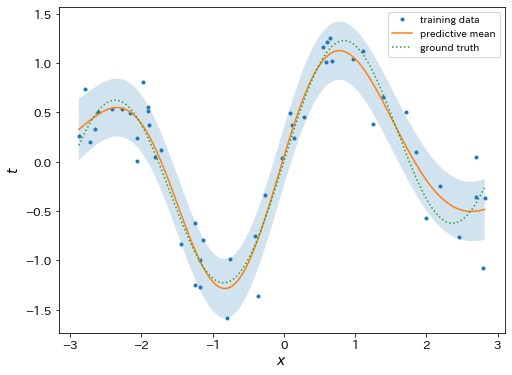

In [42]:
from sklearn.linear_model import BayesianRidge

reg = BayesianRidge(fit_intercept=False)

mus = np.reshape(np.linspace(-3, 3, 16), (16, 1))
params = {'s':s, 'mus':mus}

Phi = gen_desmat_gaussian(X, params= {'s':s, 'mus':mus})
reg.fit(Phi, t)

Phi_test = gen_desmat_gaussian(Xtest, params)
pred_mean, pred_std = reg.predict(Phi_test, return_std=True)

print(f's={s}\nalpha={reg.lambda_} \nbeta={reg.alpha_}')
plot_result(pred_mean, pred_std)
plt.show()

## 図3.8 ベイズ線形回帰の再現
http://tkzs.hatenablog.com/entry/2015/09/26/114138

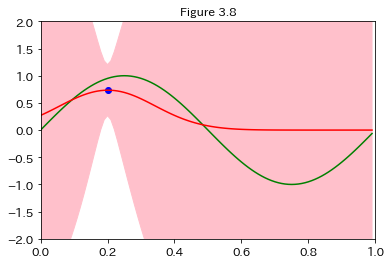

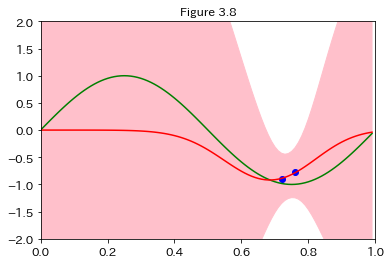

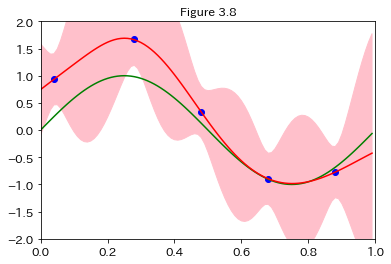

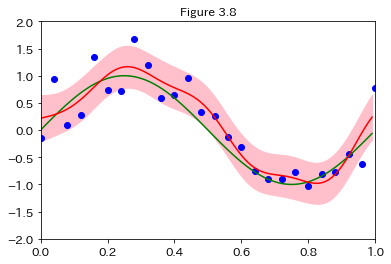

In [55]:
import numpy as np
from numpy.linalg import inv
import pandas as pd
from pylab import *
import matplotlib.pyplot as plt
%matplotlib inline

def func(x_train, y_train):
    # (3.4) ガウス基底関数
    def phi(s, mu_i, M, x):
        return np.array([exp(-(x - mu)**2 / (2 * s**2)) for mu in mu_i]).reshape((M, 1))

    #(3.53)' ((1.70)) 予測分布の平均
    def m(x, x_train, y_train, S):
        sum = np.array(zeros((M, 1)))
        for n in arange(len(x_train)):
            sum += np.dot(phi(s, mu_i, M, x_train[n]), y_train[n])
        return Beta * phi(s, mu_i, M, x).T.dot(S).dot(sum)
    
    #(3.59)'((1.71)) 予測分布の分散
    def s2(x, S):
        return 1.0/Beta + phi(s, mu_i, M, x).T.dot(S).dot(phi(s, mu_i, M, x))

    #(3.53)' ((1.72))
    def S(x_train, y_train):
        I = np.identity(M)
        Sigma = np.zeros((M, M))
        for n in range(len(x_train)):
            Sigma += np.dot(phi(s, mu_i, M, x_train[n]), phi(s, mu_i, M, x_train[n]).T)
        S_inv = alpha*I + Beta*Sigma
        S = inv(S_inv)
        return S
    
    #params for prior probability
    alpha = 0.1
    Beta = 9
    s = 0.1

    #use 9 gaussian basis functions
    M = 9

    # Assign basis functions
    mu_i = np.linspace(0, 1, M)
    
    S = S(x_train, y_train)

    #Sine curve
    x_real = np.arange(0, 1, 0.01)
    y_real = np.sin(2*np.pi*x_real)
    
    #Seek predictive distribution corespponding to entire x
    mean = [m(x, x_train, y_train, S)[0,0] for x in x_real]
    variance = [s2(x, S)[0,0] for x in x_real]
    SD = np.sqrt(variance)
    upper = mean + SD
    lower = mean - SD
    
    plot(x_train, y_train, 'bo')
    plot(x_real, y_real, 'g-')
    plot(x_real, mean, 'r-')
    fill_between(x_real, upper, lower, color='pink')
    xlim(0.0, 1.0)
    ylim(-2, 2)
    title("Figure 3.8")
    show()

if __name__ == "__main__":
    # Maximum observed data points (underlining function plus some noise)
    x_train = np.linspace(0, 1, 26)

    #Set "small level of random noise having a Gaussian distribution"
    loc = 0
    scale = 0.3
    y_train =  np.sin(2*np.pi*x_train) + np.random.normal(loc,scale,26)


    #Sample data pick up
    def randidx(n, k):
        r = [i for i in range(n)]
        shuffle(r)
        return sort(r[0:k])

    for k in (1, 2, 5, 26):
        indices = randidx(size(x_train), k)
        func(x_train[indices], y_train[indices])